In [1]:
import sys
import os
import struct
import time
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
%matplotlib inline

fpX = np.float32

import torch 
root = os.path.dirname(os.path.dirname(os.getcwd()))
sys.path.append(os.path.join(root, 'code'))
from utils import plot_utils
plot_utils.set_plotting_defaults()

In [3]:
# Load results of the fitting procedure

subject = 1
volume_space=True
n_from_end = 0; # if zero, load most recent; if positive, load second most recent etc.

fitting_type = 'bdcn_pca_fused'

root = os.path.dirname(os.path.dirname(os.getcwd()))
if volume_space:
    folder2load = os.path.join(root, 'model_fits','S%02d'%subject, fitting_type)
else:
    folder2load = os.path.join(root, 'model_fits','S%02d_surface'%subject, fitting_type)
# within this folder, assuming we want the most recent version that was saved
files_in_dir = os.listdir(folder2load)
from datetime import datetime
my_dates = [f for f in files_in_dir if 'ipynb' not in f and 'DEBUG' not in f]
my_dates.sort(key=lambda date: datetime.strptime(date, "%b-%d-%Y_%H%M_%S"))
most_recent_date = my_dates[-1-n_from_end]

# most_recent_date = 'Aug-30-2021_0807_16'
# most_recent_date = 'Aug-30-2021_2008_22'
# most_recent_date = 'Jul-06-2021_0356'

subfolder2load = os.path.join(folder2load, most_recent_date)
file2load = os.listdir(subfolder2load)[0]
fullfile2load = os.path.join(subfolder2load, file2load)

print('loading from %s\n'%fullfile2load)

out = torch.load(fullfile2load)
print(out.keys())

fig_save_folder = os.path.join(root,'figures','S%02d'%subject, fitting_type, most_recent_date)
if not os.path.exists(fig_save_folder):
    os.makedirs(fig_save_folder)

loading from /user_data/mmhender/imStat/model_fits/S01/bdcn_pca_fused/Sep-02-2021_0507_59/all_fit_params

dict_keys(['aperture', 'aperture_rf_range', 'models', 'voxel_mask', 'brain_nii_shape', 'image_order', 'voxel_index', 'voxel_roi', 'voxel_ncsnr', 'best_params', 'pc', 'lambdas', 'best_lambdas', 'best_losses', 'val_cc', 'val_r2', 'zscore_features', 'n_prf_sd_out', 'mult_patch_by_prf', 'do_nms', 'downsample_factor', 'ridge', 'do_pca', 'debug', 'up_to_sess', 'shuff_rnd_seed'])


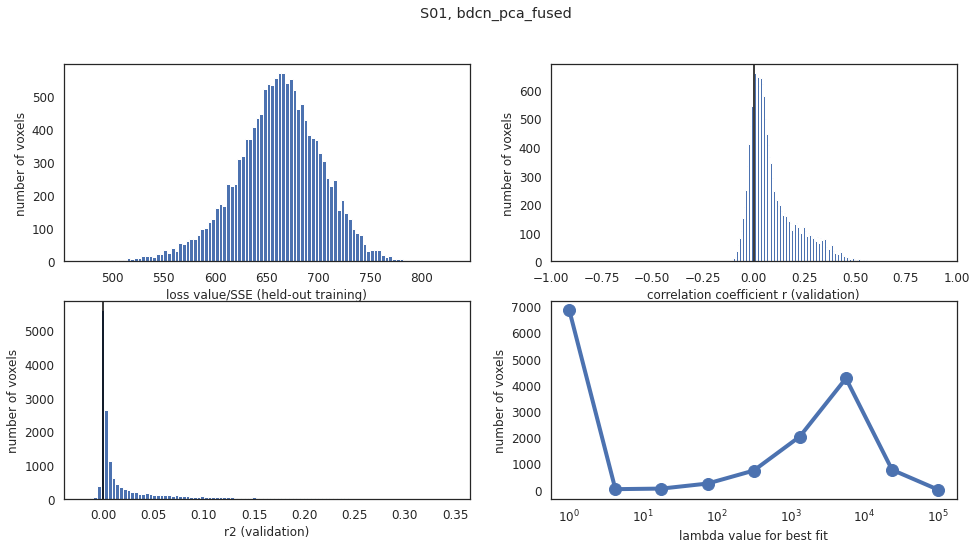

In [6]:
plot_utils.plot_perf_summary(subject, fitting_type, out, fig_save_folder=fig_save_folder)

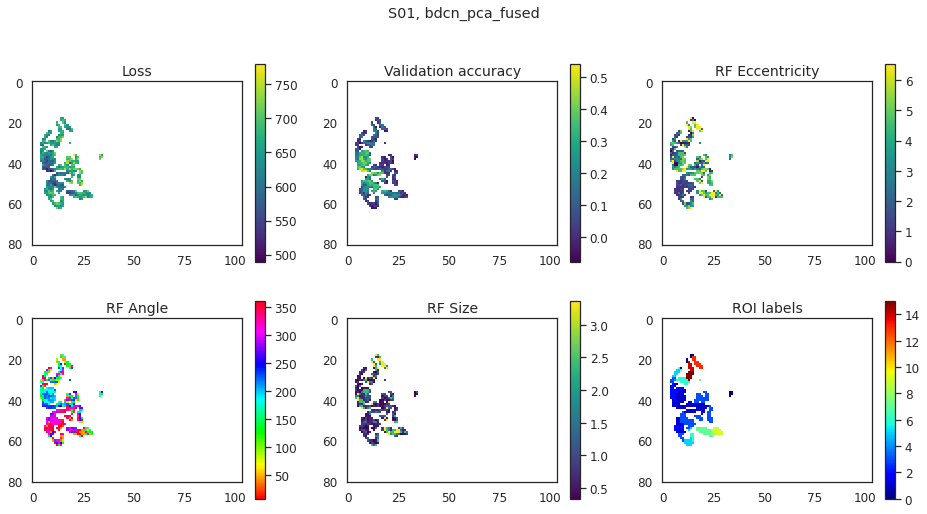

In [7]:
plot_utils.plot_fit_summary_volume_space(subject, fitting_type,out, fig_save_folder)

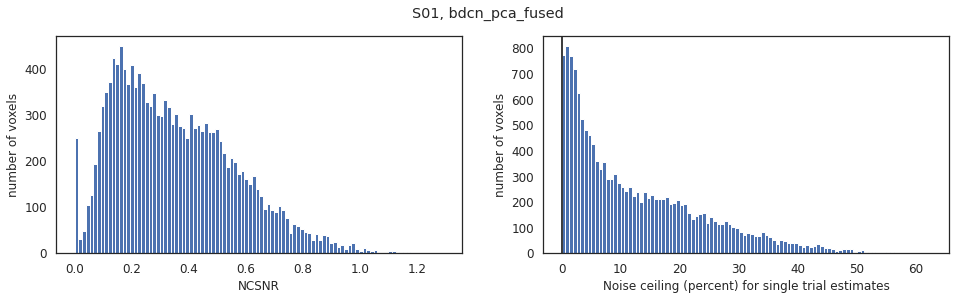

In [8]:
plot_utils.plot_noise_ceilings(subject, fitting_type,out, fig_save_folder)

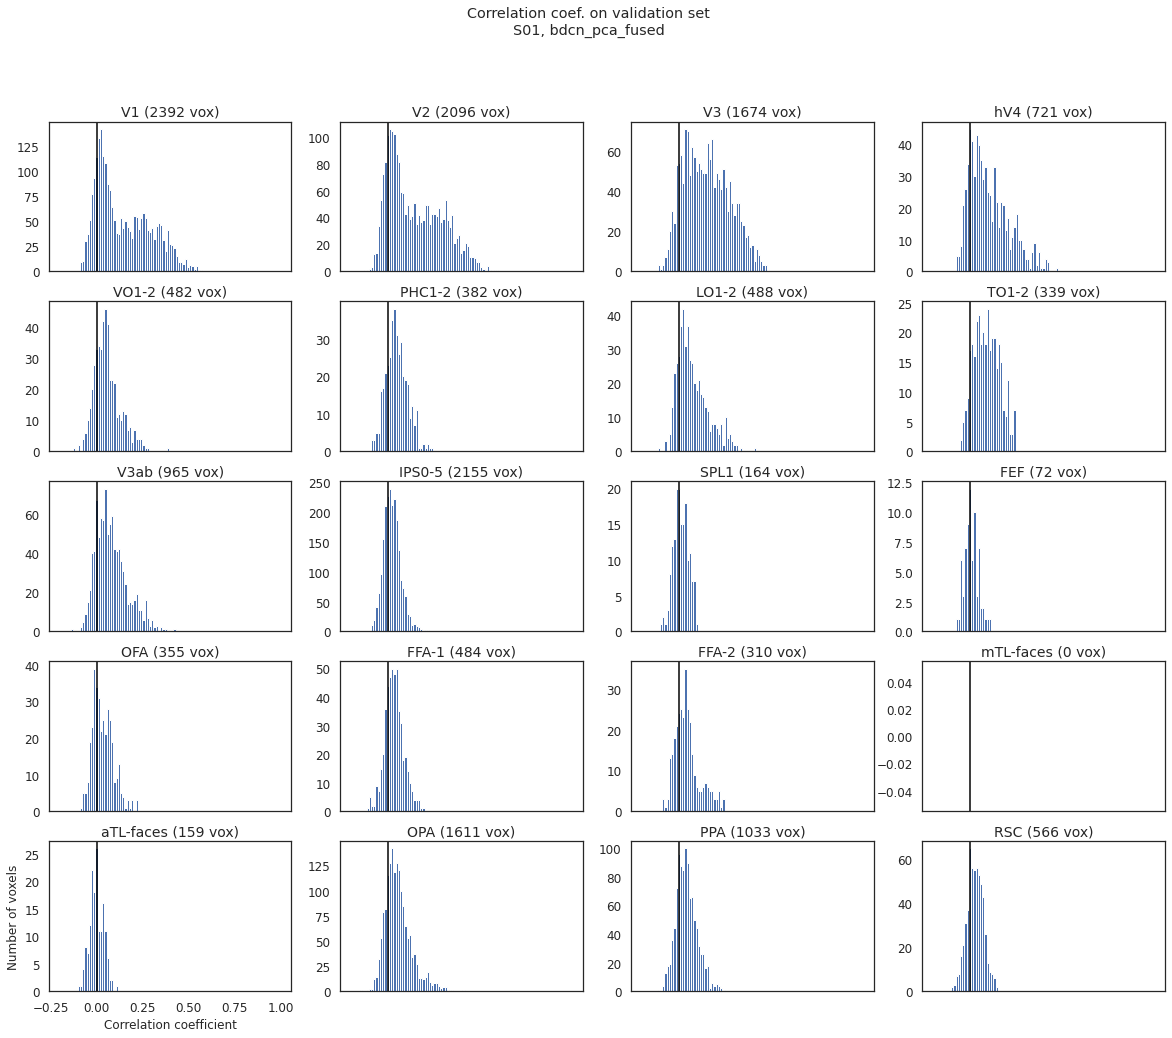

In [9]:
plot_utils.plot_cc_each_roi(subject, fitting_type,out, fig_save_folder)

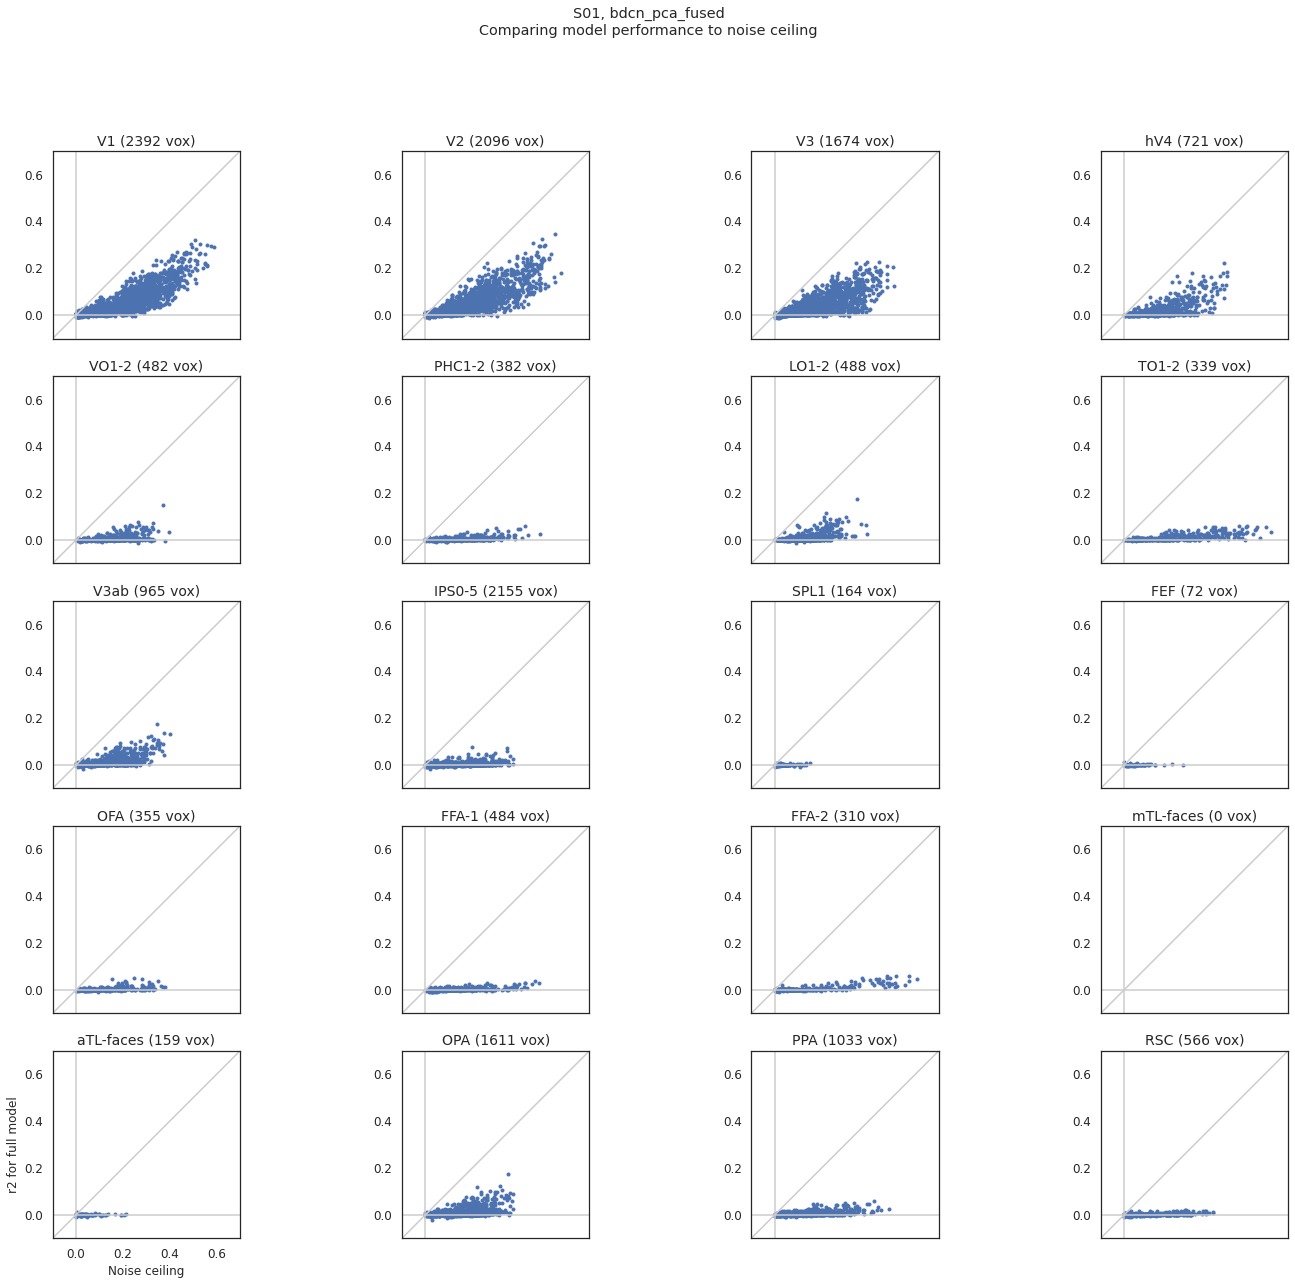

In [10]:
plot_utils.plot_r2_vs_nc(subject, fitting_type,out, fig_save_folder)

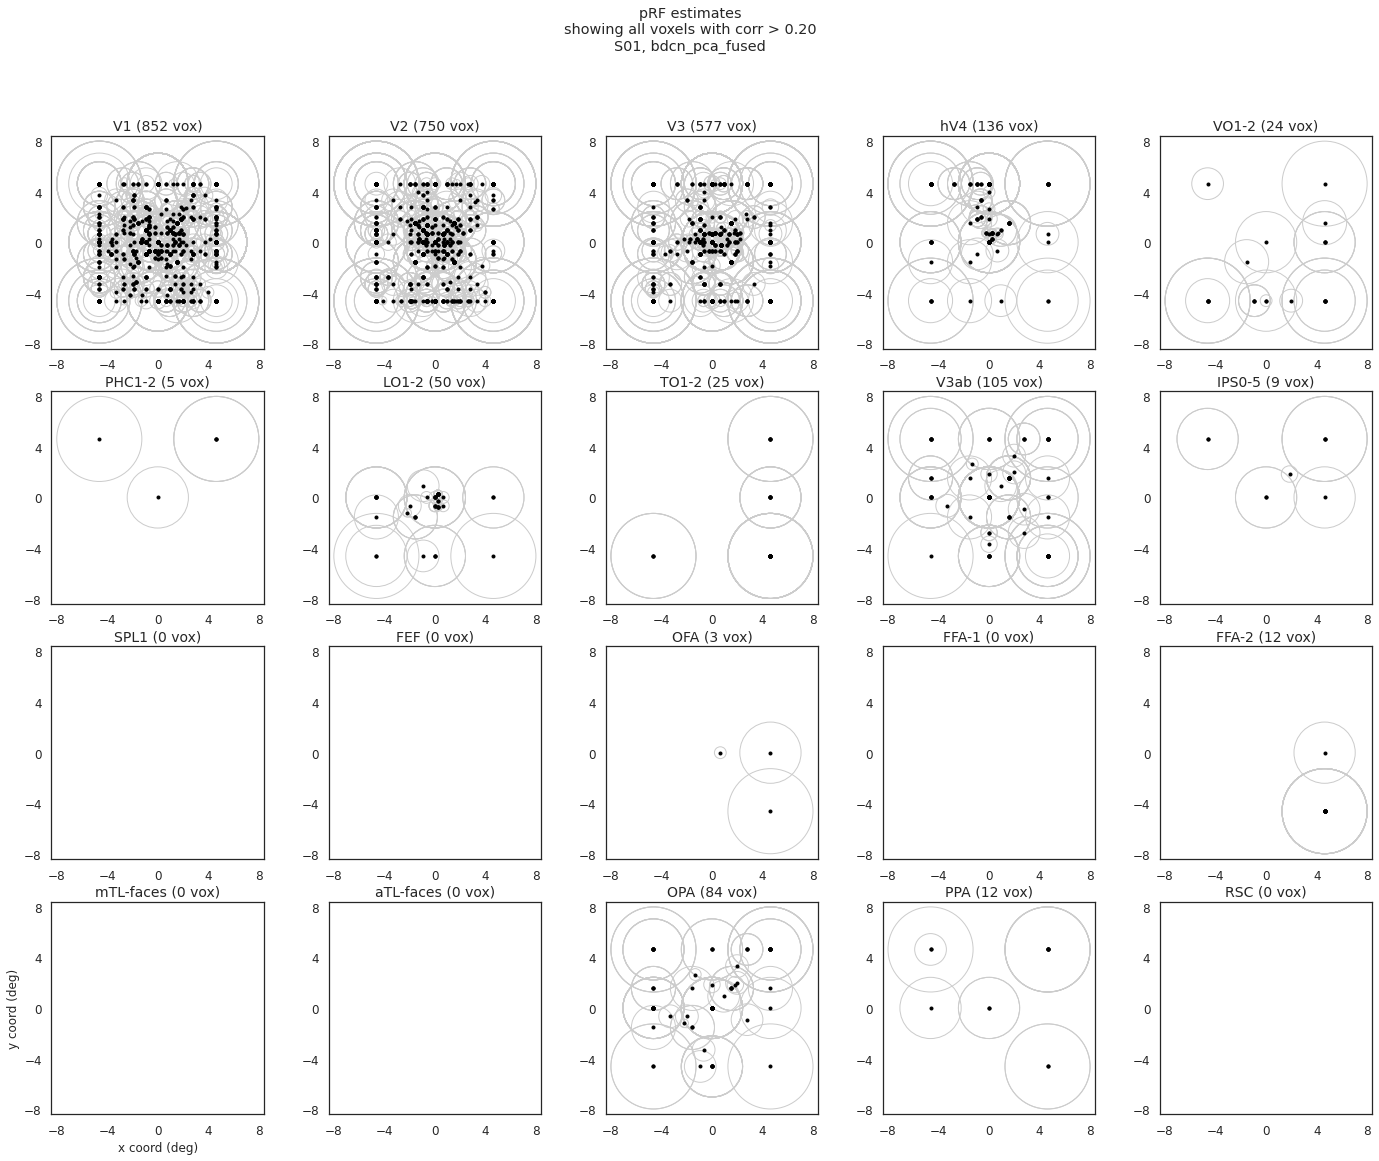

In [12]:
plot_utils.plot_spatial_rf_circles(subject, fitting_type,out, cc_cutoff = 0.20, fig_save_folder=fig_save_folder)

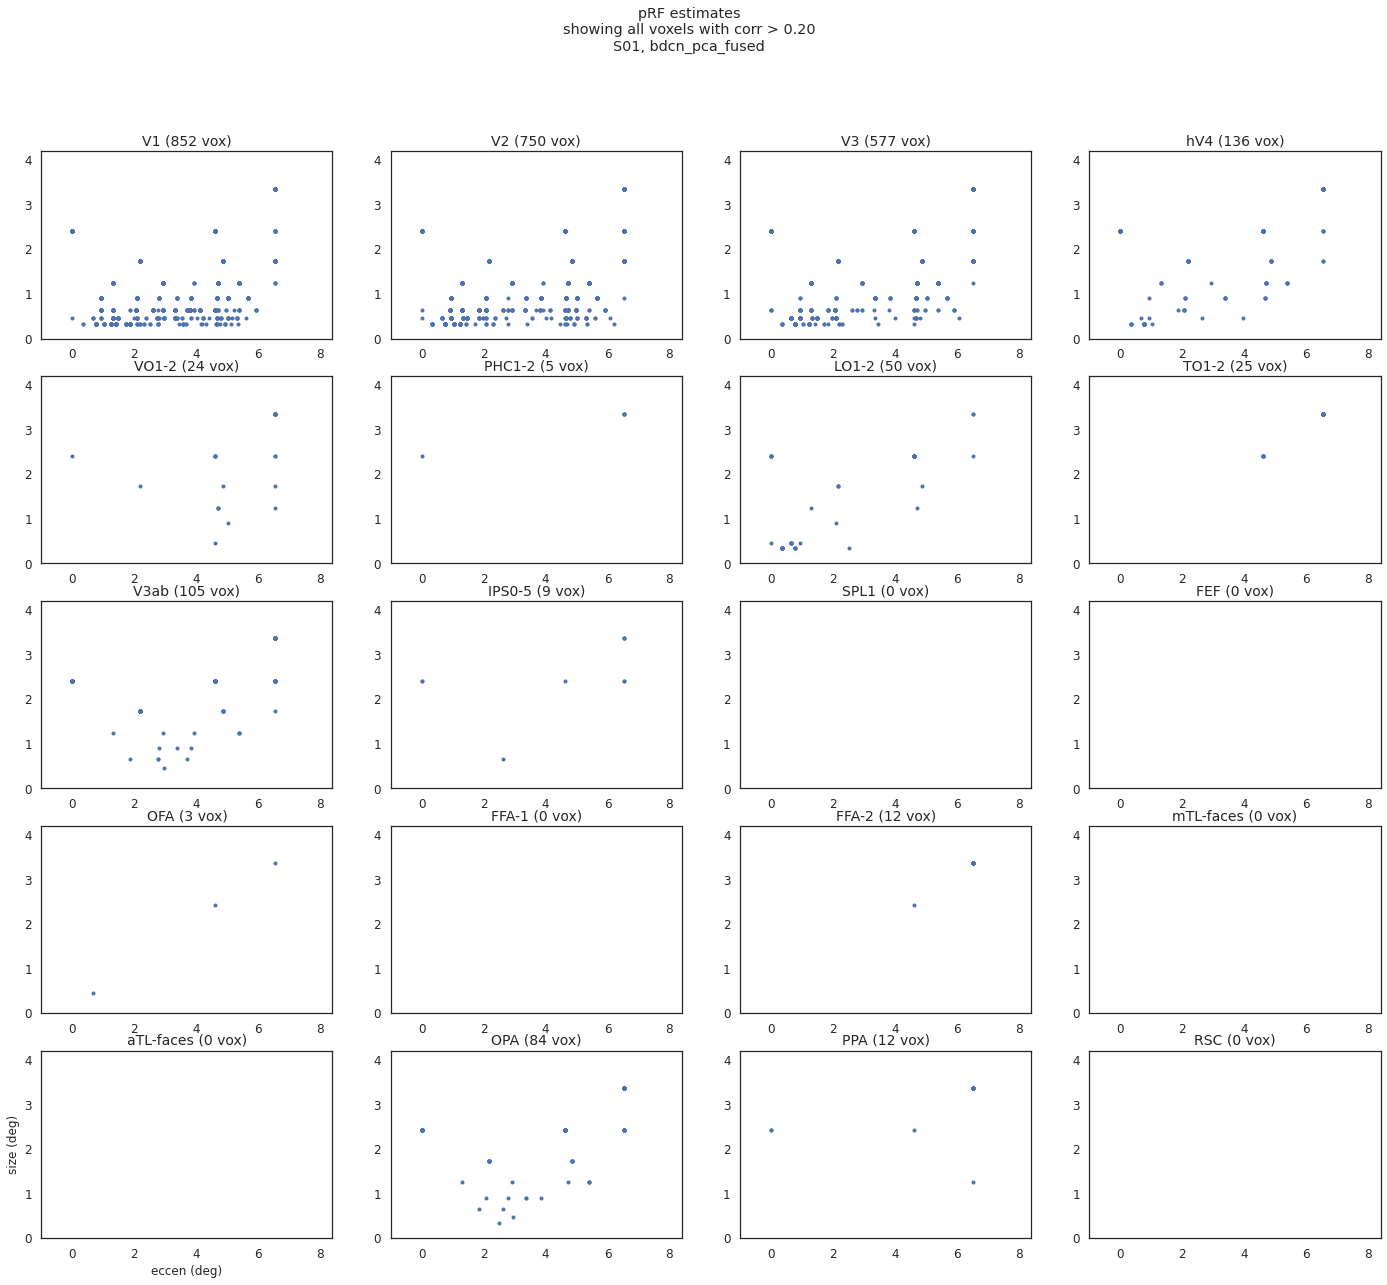

In [4]:
plot_utils.plot_size_vs_eccen(subject, fitting_type, out, cc_cutoff=0.2, fig_save_folder=fig_save_folder)

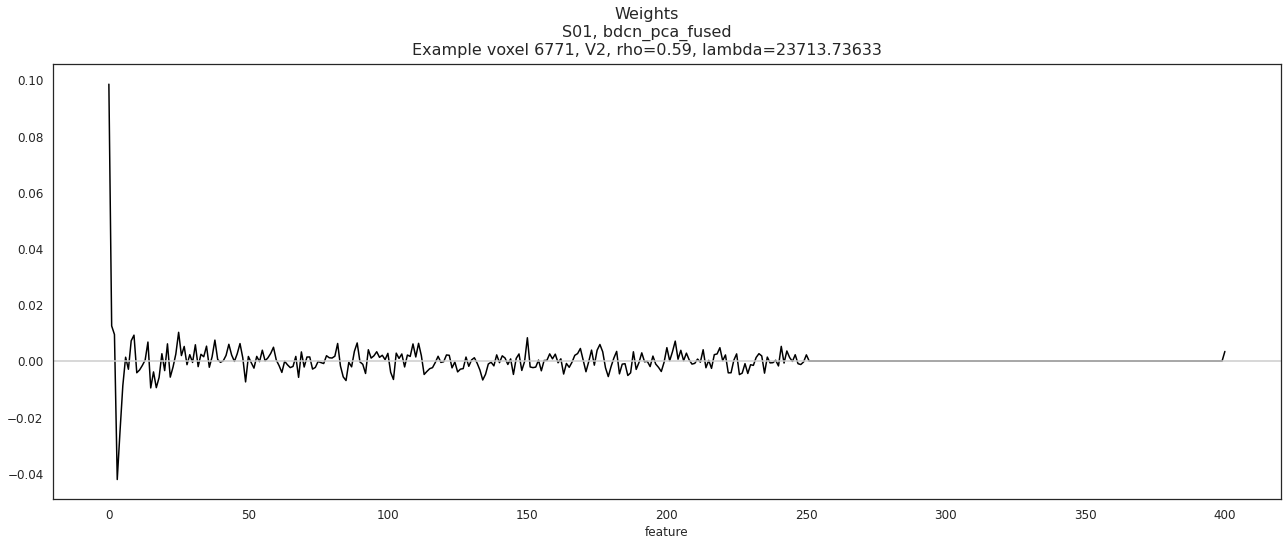

In [23]:
# Plotting some example weights...

from copy import deepcopy
roi_labels_retino, roi_labels_categ, ret_group_inds, categ_group_inds, ret_group_names, categ_group_names, \
        n_rois_ret, n_rois_categ, n_rois = plot_utils.get_roi_info(subject, out)

pp=0
val_cc = out['val_cc'][:,0]
lambdas = out['lambdas']
best_lambdas = out['best_lambdas']
vox2plot = np.argsort(np.nan_to_num(val_cc))[-1] # choosing vox w best validation set performance

vv=vox2plot

plt.figure(figsize=(22,8))

weights = out['best_params'][1]
wts = weights[vv,:]
plt.plot(wts,'-',color='k')

plt.axhline(0,color=[0.8, 0.8, 0.8])

plt.xlabel('feature')

roi_ind_ret = np.where([np.isin(roi_labels_retino[vv], ret_group_inds[ii]) for ii in range(len(ret_group_inds))])[0]
roi_ind_categ = np.where([np.isin(roi_labels_categ[vv], categ_group_inds[ii]) for ii in range(len(categ_group_inds))])[0]
if len(roi_ind_ret)==0:
    rname = categ_group_names[roi_ind_categ[0]]
elif len(roi_ind_categ)==0:
    rname = ret_group_names[roi_ind_ret[0]]
else:
    rname = '%s/%s'%(ret_group_names[roi_ind_ret[0]],categ_group_names[roi_ind_categ[0]])
    
plt.title(''%())

plt.suptitle('Weights\nS%02d, %s\nExample voxel %d, %s, rho=%.2f, lambda=%.5f'%( subject, fitting_type,vv,rname, val_cc[vv],lambdas[best_lambdas[vv]]),fontsize=16);
